## <b> Problem Description </b>

### The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe a term deposit (variable y).


## <b> Data Description </b>

## <b>Input variables: </b>
### <b> Bank Client data: </b>

* age (numeric)
* job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* default: has credit in default? (categorical: 'no','yes','unknown')
* housing: has housing loan? (categorical: 'no','yes','unknown')
* loan: has personal loan? (categorical: 'no','yes','unknown')

### <b> Related with the last contact of the current campaign:</b>
* contact: contact communication type (categorical: 'cellular','telephone')
* month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### <b>Other attributes: </b>
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


### <b>Output variable (desired target):</b>
* y - has the client subscribed a term deposit? (binary: 'yes','no')

# **Importing Libraries**

In [1]:
# Importing data analysis and visualisation libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [2]:
# Importing feature engineering and model training libraries

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.model_selection import LearningCurve, validation_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from utils import sine_cosine_transform, target_encoding, ordinal_encoding, onehot_encoding
from utils import handling_outliers, evaluate, plot_learning_curves, stratified_kfold
import joblib


import warnings
warnings.filterwarnings("ignore")

In [3]:
# Configuration for matplotlib graphs

matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style('darkgrid');

# **Reading the data**

In [4]:
# Loading the dataset 

path = "D:/ML Projects/Bank Marketing Effectiveness Prediction/bank-full.csv"
bank_df = pd.read_csv(path, sep = ";")

In [5]:
# Displaying the first five rows of the dataset

bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
# Displaying the last five rows of the dataset

bank_df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [7]:
# Size of the dataset

bank_df.shape

(45211, 17)

The dataset consists of 45211 rows and 17 columns.

In [8]:
# Checking for duplicate rows in the data

bank_df.duplicated().sum()

0

There are no duplicate rows in the dataset.

In [9]:
# Checking for any Null values

bank_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no missing values in the dataset.

In [10]:
# Checking the data types of variables

bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

The datatypes of all variables are appropriate.

# **Exploratory Data Analysis**

### **Distribution of target variable**

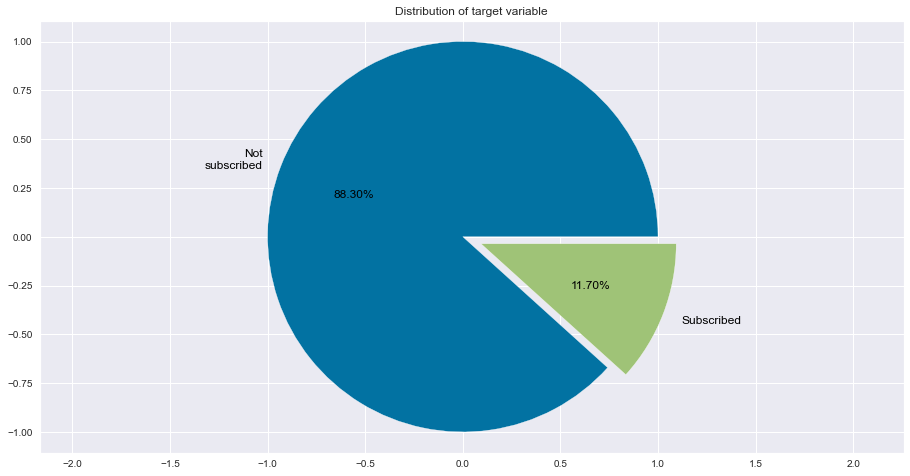

In [11]:
# Distribution of target variable

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.pie(bank_df["y"].value_counts(), labels = ["Not\nsubscribed", "Subscribed"],
        explode = (0, 0.1), autopct = "%1.2f%%", frame = True, textprops = dict(color = "black", size = 12))
ax.axis("equal")
plt.title("Distribution of target variable")

plt.show()

**Insights:**
* The target variable class is highly imbalanced.

In the later stage, I'll address the class imbalance by removing the majority class instances from each pair of close instances of the opposite class which increases the space between the two classes, as well as penalising learning algorithms that will increase the cost of classification mistakes on the minority class.

### **Representation of numerical features**

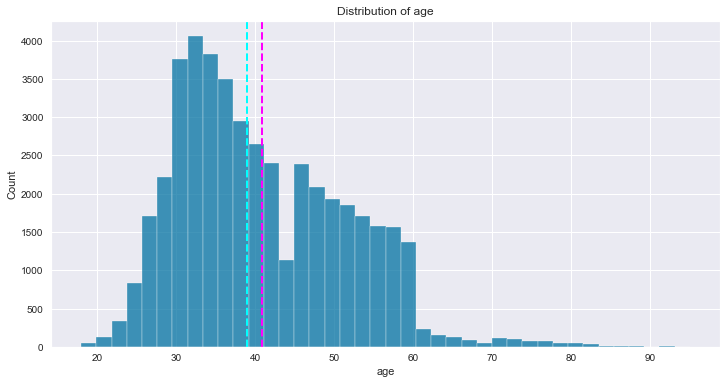

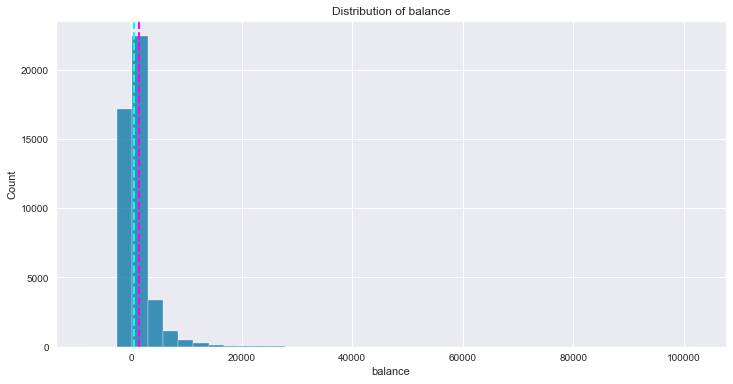

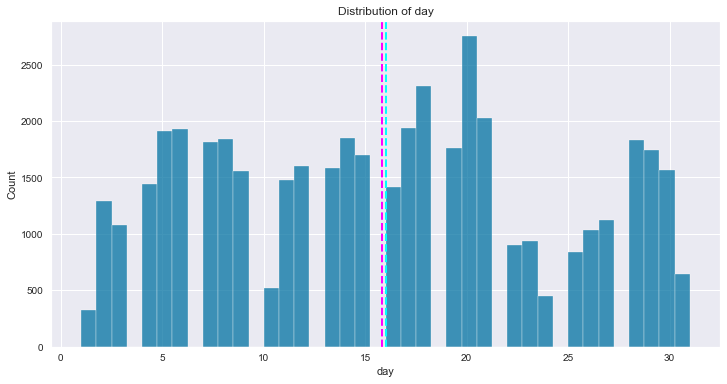

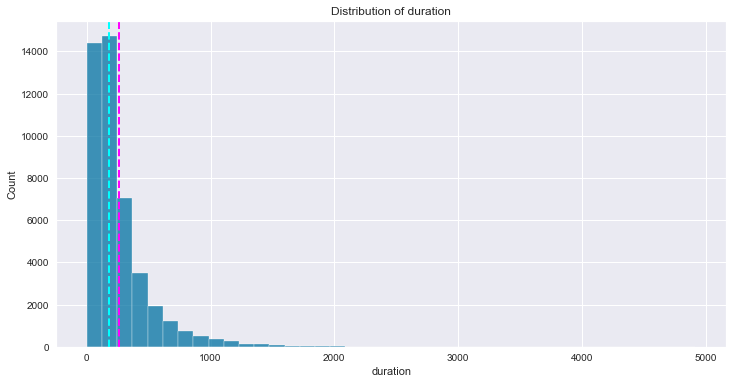

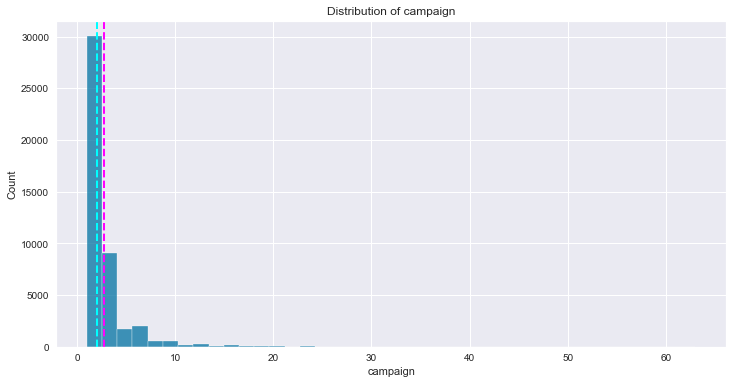

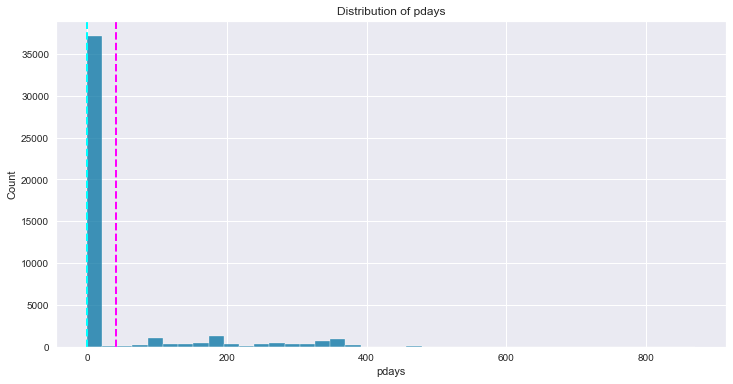

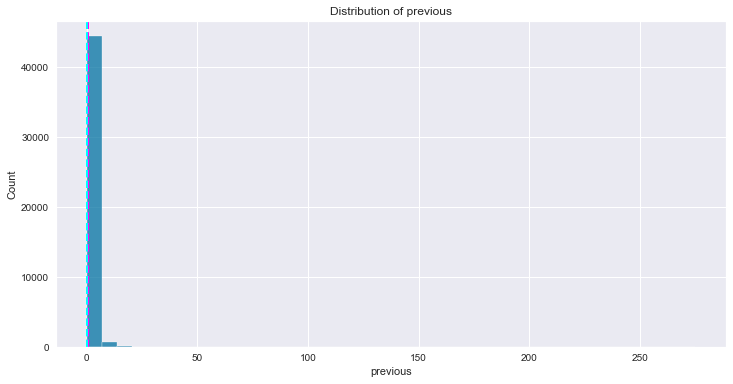

In [12]:
# Distribution of numerical features

numeric_cols = bank_df.describe().columns
for col in numeric_cols:
  fig = plt.figure(figsize = (12, 6))
  ax = fig.gca()
  feature = bank_df[col]
  sns.histplot(feature, ax = ax, bins = 40)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(f"Distribution of {col}") 

plt.show()

**Insights**:
* It seems numerical features are highly skewed. It might be due to the presence of outliers in the features.

As numerical features consists of extreme values. Let's take a deeper look at those features so that I can have a sense of how to deal with them eventually.

In [13]:
# Descriptive summary of skewed features

bank_df[["age", "balance", "campaign", "pdays", "previous"]].describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [14]:
# Percentage of "pdays" value above 365

len(bank_df[bank_df["pdays"] > 365]) * 100/ len(bank_df)

1.4222202561323571

Only 1.4% of pdays have a value greater than 365.


In [15]:
# Percentage of "campaign" value above 14

len(bank_df[bank_df["campaign"] > 14]) * 100 / len(bank_df)

1.3580765742850192

Only 1.3% of campaign have a value greater than 14.


In [16]:
# Percentage of "previous" value above 10

len(bank_df[bank_df["previous"] > 7]) * 100 / len(bank_df)

1.2872973391431288

Only 1.2% of previous have a value greater than 10.


In [17]:
# Percentage of "balance" value below -1000

len(bank_df[bank_df["balance"] < -1000]) * 100 / len(bank_df)

0.3185065581385061

Only 0.3% of balance have a value less than -1000.

In [18]:
# Percentage of "balance" value above 15000

len(bank_df[bank_df["balance"] > 15000]) * 100 / len(bank_df)

0.7763597354626086

Only 0.77% of balance have a value greater than 15000.

In [19]:
# Percentage of "age" value above 70

len(bank_df[bank_df["age"] > 70]) * 100 / len(bank_df)

1.0771714848156422

Only 1.07% of age have a value greater than 70.

When dealing with these features, I would use threshold values to cap the extreme values of these features.

### **Representation of age and subscription rate**

In [20]:
# Function to calculate Subscription rate

def crosstab_plot(feature, label):
  crosstab = pd.crosstab(feature, label, normalize = "index")
  crosstab["subscribed_percentage"] = crosstab["yes"] * 100
  crosstab.drop(columns = ["yes", "no"], inplace = True)
  if feature.name == "month":
    months_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
    sns.pointplot(x = crosstab.index, y = crosstab["subscribed_percentage"], order = months_order)
  else:
    if len(crosstab.index) > 5:
      sns.barplot(x = crosstab["subscribed_percentage"], y = crosstab.index)
    else:
      sns.barplot(x = crosstab.index, y = crosstab["subscribed_percentage"])

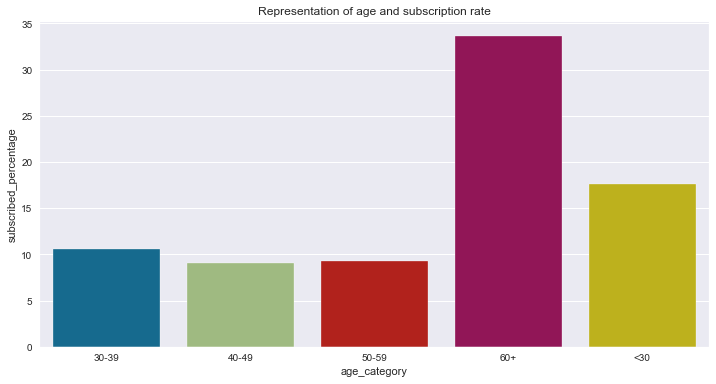

In [21]:
# Representation of age and subscription rate

def age_category(x):
    if x < 30:
        x = "<30"
    elif (x >= 30) & (x < 40):
        x = "30-39"
    elif (x >= 40) & (x < 50):
        x = "40-49"
    elif (x >= 50) & (x < 60):
        x = "50-59"
    else:
        x = "60+"
    return x

bank_df["age_category"] = bank_df["age"].apply(age_category)
crosstab_plot(bank_df["age_category"], bank_df["y"])
plt.title("Representation of age and subscription rate")

plt.show()

**Insights**
* Customers above the age of 60 and under the age of 30 are more interested in term deposits.

### **Representation of balance and subscription rate**

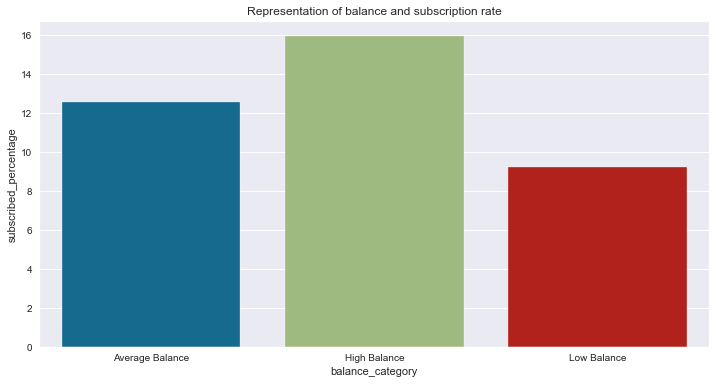

In [22]:
# Representation of balance and subscription rate

def balance_category(x):
    if x <= 500:
        x = "Low Balance"
    elif (x > 500) & (x <= 1350):
        x = "Average Balance"
    else:
        x = "High Balance"  
    return x

bank_df["balance_category"] = bank_df["balance"].apply(balance_category)
crosstab_plot(bank_df["balance_category"], bank_df["y"])
plt.title("Representation of balance and subscription rate")

plt.show()

**Insights:**
* Customers with a medium to high amount are more likely to opt for a term deposit.

### **Representation of job and subscription rate**

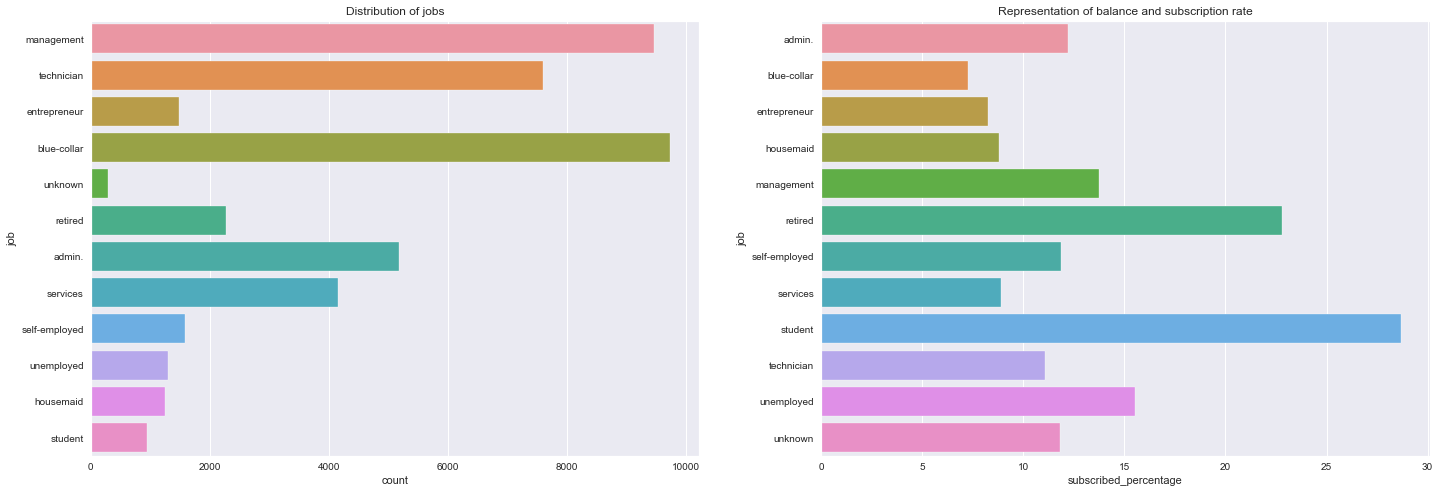

In [23]:
# Representation of job and subscription rate

plt.figure(figsize = (24, 8))
plt.subplot(1, 2, 1)
sns.countplot(y = "job", data = bank_df)
plt.title("Distribution of jobs")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["job"], bank_df["y"])
plt.title("Representation of balance and subscription rate")

plt.show()

**Insights:**
* Although the majority of the bank's customers are employed in blue collar and management roles, term deposits are more popular among students and retirees.

### **Representation of marital status and subscription rate**

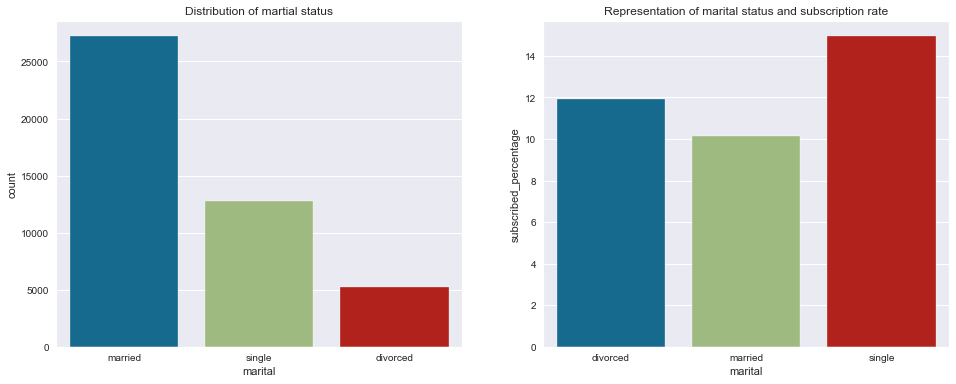

In [24]:
# Representation of marital status and subscription rate

plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = "marital", data = bank_df)
plt.title("Distribution of martial status")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["marital"], bank_df["y"])
plt.title("Representation of marital status and subscription rate")

plt.show()

**Insights:**
* Despite the fact that the majority of customers are married, singles have a higher subscription rate.

### **Representation of education and subscription rate**

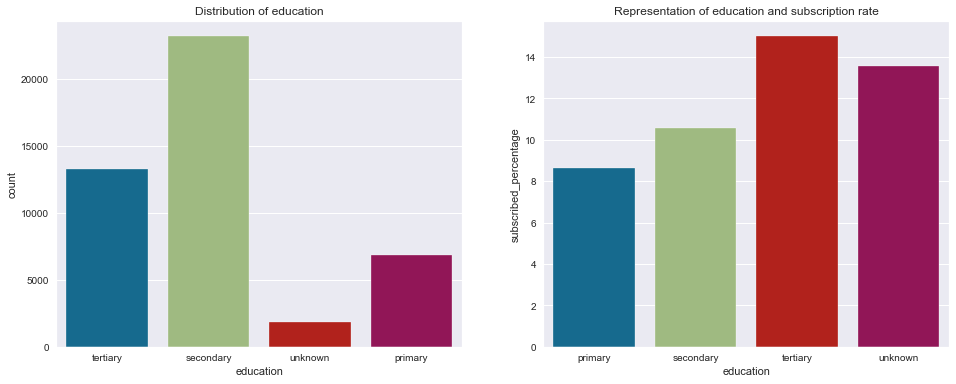

In [25]:
# Representation of education and subscription rate

plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = "education", data = bank_df)
plt.title("Distribution of education")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["education"], bank_df["y"])
plt.title("Representation of education and subscription rate")

plt.show()

**Insights:**
* The majority of the bank clients are secondary passed.
* It seems that as the level of education goes up, more customers subscribe for term deposit.

### **Representation of default and subscription rate**

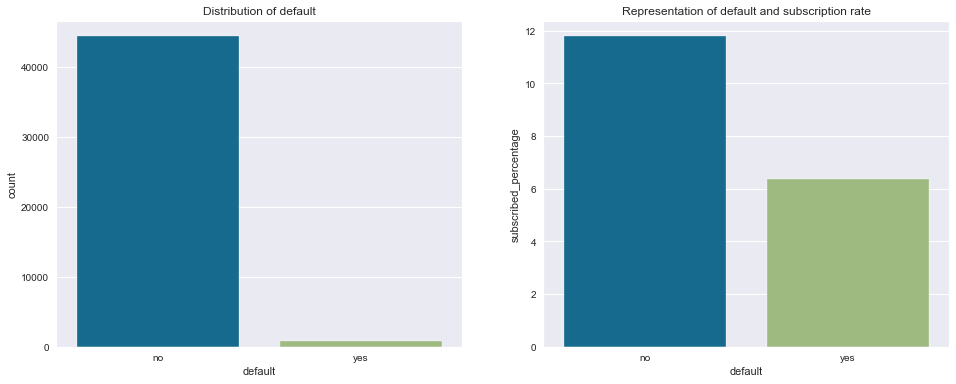

In [26]:
# Representation of default and subscription rate

plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = "default", data = bank_df)
plt.title("Distribution of default")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["default"], bank_df["y"])
plt.title("Representation of default and subscription rate")

plt.show()

**Insights:**
* Customers with no default are more interested in term deposits.

### **Representation of housing loan**

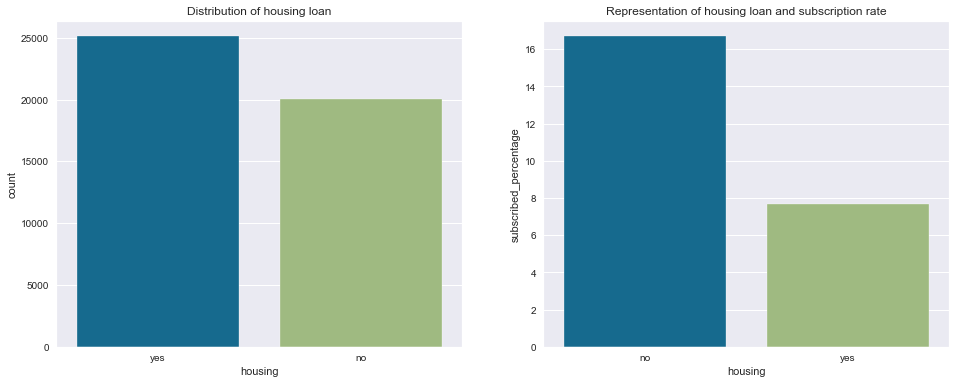

In [27]:
# Representation of housing loan and subscription rate

plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = "housing", data = bank_df)
plt.title("Distribution of housing loan")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["housing"], bank_df["y"])
plt.title("Representation of housing loan and subscription rate")

plt.show()

**Insights:**
* Despite the fact that the majority of clients have a home mortgage, no-loan clients have a higher subscription rate.

### **Representation of personal loan and subscription rate**

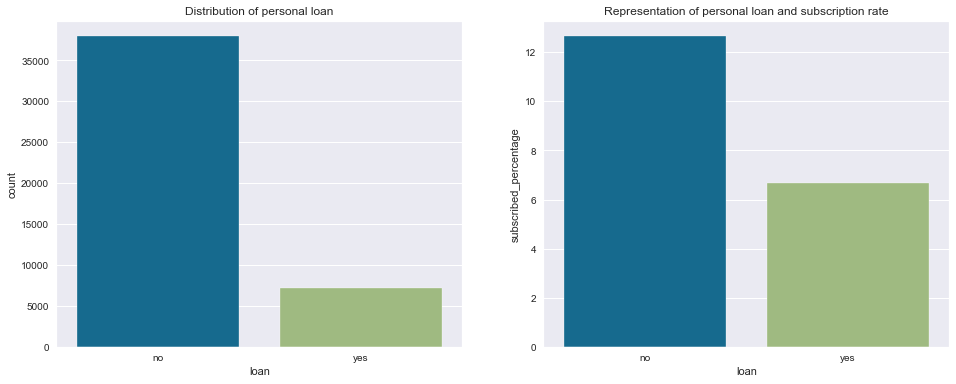

In [28]:
# Representation of personal loan and subscription rate

plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = "loan", data = bank_df)
plt.title("Distribution of personal loan")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["loan"], bank_df["y"])
plt.title("Representation of personal loan and subscription rate")

plt.show()

**Insights:**
* Customers with no personal loan have higher subscription rate.

### **Representation of last month and subscription rate**

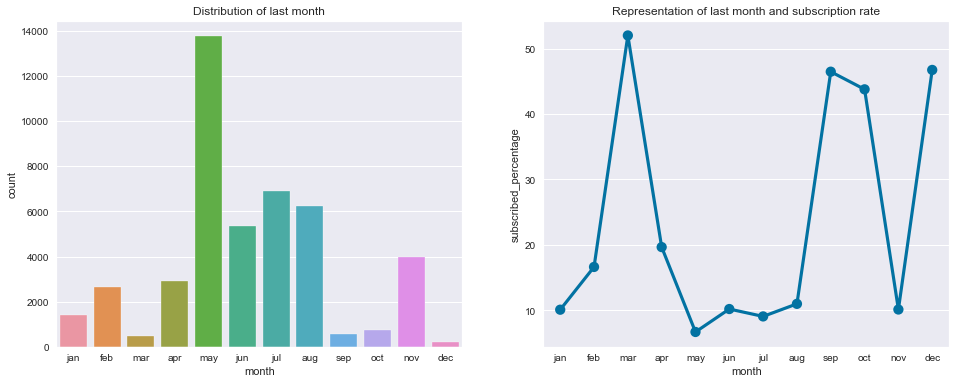

In [29]:
# Representation of last month and subscription rate

months_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = "month", data = bank_df, order = months_order)
plt.title("Distribution of last month")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["month"], bank_df["y"])
plt.title("Representation of last month and subscription rate")

plt.show()

**Insights**:
* Clients that were approached in March, September, October and December have a higher subscription rate.

### **Representation of previous outcome and subscription rate**

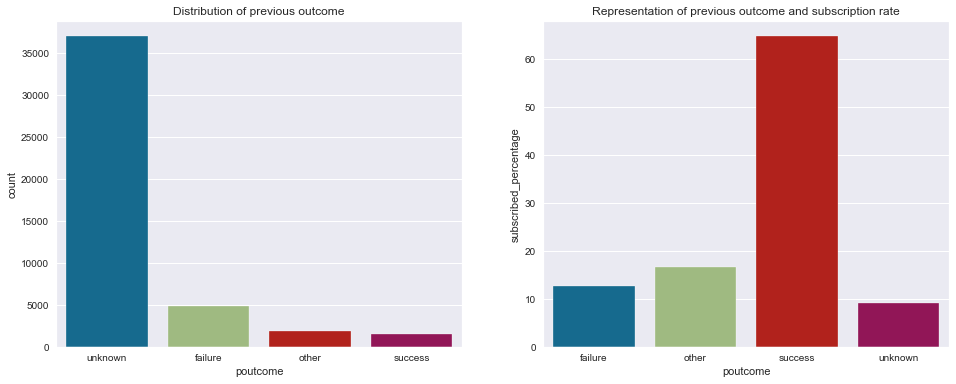

In [30]:
# Representation of previous outcome and subscription rate

plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(x = "poutcome", data = bank_df)
plt.title("Distribution of previous outcome")
plt.subplot(1, 2, 2)
crosstab_plot(bank_df["poutcome"], bank_df["y"])
plt.title("Representation of previous outcome and subscription rate")

plt.show()

**Insights:**
* The majority of the preceding campaign's outcomes are unknown. It could be due to poor marketing management or the fact that the account has been opened by a large number of new clients.
* The majority of clients who availed in previous services are more likely to apply for a term deposit.

### **Correlation Matrix**

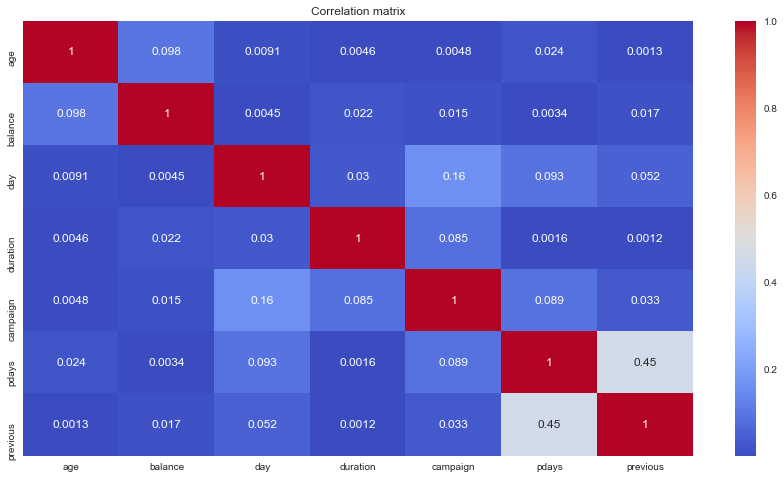

In [31]:
# Correlation matrix

plt.figure(figsize = (15, 8))
correlation = bank_df.corr()
sns.heatmap(abs(correlation), annot = True, cmap = "coolwarm")
plt.title("Correlation matrix")

plt.show()

**Insights:**
* No multicollinearity is present in the data.

# **Data Preparation**

In [32]:
# Dropping columns that were just for visualisation purposes

bank_df.drop(columns = ["age_category", "balance_category", "duration"], inplace = True)

In [33]:
# Performing mathematical(sine & cosine) transformation on month column

bank_df["month_sin"], bank_df["month_cos"] = sine_cosine_transform(bank_df, feature = "month")

Sine and cosine transformations on month features will depict the feature as (x, y) coordinates of a circle, helping the algorithms to better interpret it as cyclic in nature, improving the prediction power.

In [34]:
# Performing Target encoding on job column

job_temp = bank_df["job"]
bank_df["job"] = target_encoding(bank_df, feature = "job", label = "y")
job_mapping = dict(zip(job_temp, bank_df["job"]))
joblib.dump(job_mapping, "job_mapping.pkl")

['job_mapping.pkl']

By using the target encoding job feature, the risk of high cardinality is reduced which could have occurred if one-hot encoding is used.

In [35]:
# Perfoming Ordinal encoding on education column

bank_df["education"] = ordinal_encoding(bank_df, feature = "education")

As sub-categories of education are ordinal in nature, therefore using ordinal encoding to the transform the education feature is a natural choice.

In [36]:
# Perfoming one hot encoding on the remaining categorical columns

bank_df = onehot_encoding(bank_df, features = ["marital", "default", "housing", "loan", "poutcome", "contact"])

At last for all the remaining categorical features one-hot encoding is used which would allow the representation of categorical data to be more expressive.

In [37]:
# Dropping month column to avoid multicollinearity

bank_df.drop(columns = "month", inplace = True)

In [38]:
# Performing Label encoding on target variable

label_mapping = {"yes": 1, "no": 0}
bank_df["y"] = bank_df["y"].map(label_mapping)

In [39]:
# Handling extreme values

bank_df["pdays"] = bank_df.apply(lambda row: handling_outliers(row, "pdays", 365), axis = 1)
bank_df["campaign"] = bank_df.apply(lambda row: handling_outliers(row, "campaign", 14), axis = 1)
bank_df["previous"] = bank_df.apply(lambda row: handling_outliers(row, "previous", 7), axis = 1)
bank_df["balance"] = bank_df.apply(lambda row: handling_outliers(row, "balance", 15000, -1000), axis = 1)
bank_df["age"] = bank_df.apply(lambda row: handling_outliers(row, "age", 70), axis = 1)

As discussed earlier, the extreme values are capped with the threshold values.



In [40]:
# Dividing the dataset into train and test set using Stratified Sampling

rng = np.random.RandomState(0)
splits = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = rng)
for train_index, test_index in splits.split(bank_df, bank_df["y"]):
  train_set = bank_df.loc[train_index]
  test_set = bank_df.loc[test_index]

As the class labels is imbalanced, Stratified Sampling should be used instead of Random Sampling to ensure that the minority class is properly represented in both the train and test sets.

In [41]:
# Separating the features and target labels from the train set

subscription_labels = train_set["y"].copy()
subscription_features = train_set.drop("y", axis = 1)

In [42]:
# Separating the features and target labels from the test set

test_subscription_labels = test_set["y"].copy()
test_subscription_features = test_set.drop("y", axis = 1)

In [43]:
# Handling class imbalance using TomekLinks

sample = TomekLinks(sampling_strategy = "majority")
features, labels = sample.fit_resample(subscription_features, subscription_labels)

TomekLinks helps remove the instances of the majority class of each close pair which increases the space between the two classes, facilitating the classification process.

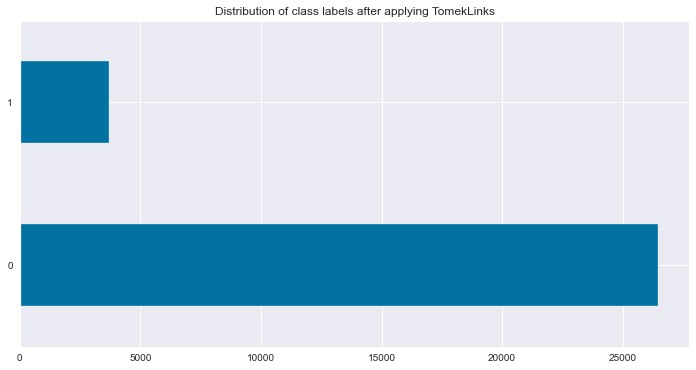

In [44]:
# Class labels after appling TomekLinks

labels.value_counts().plot(kind = "barh")
plt.title("Distribution of class labels after applying TomekLinks")

plt.show()

The class labels is still imbalanced but close pairs are removed to have a better decision boundary. Further to have good results I will penalise the learning algorithms that will increase the cost of classification mistakes on the minority class.

In [45]:
# Performing MinMax Scaling on numerical features of the training set to scale down in the range of between 0 and 1

scaler = MinMaxScaler()
data_prepared = scaler.fit_transform(features)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [46]:
# Applying the MinMax scaling on the numerical features of the test set

test_data_prepared = scaler.transform(test_subscription_features)

Applying the MinMax Scaling would result in faster training of the models.

# **Evaluation metric**

I will use balanced accuracy score to evaluate the performance of the ML models as target classes are imbalanced in nature. It accounts for both the positive and negative outcome classes and doesn’t mislead with imbalanced data. The balanced accuracy score is calculated as follows:

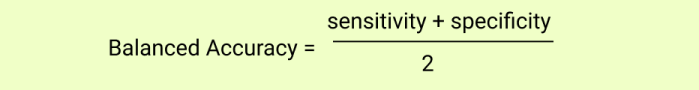


where, 



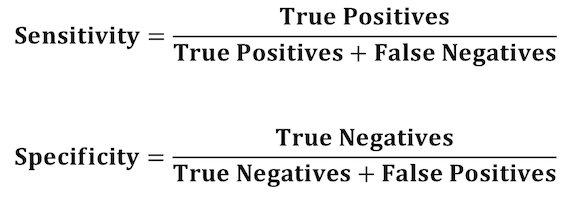

# **Model training**

## **Logistic Regression**

In [47]:
# Training the Logistic Regression model

lr = LogisticRegression()
lr.fit(data_prepared, labels)

LogisticRegression()

In [48]:
# Evaluating the performance of the model on training set

lr_score = evaluate(model = lr, data_prepared = data_prepared, label = labels)
lr_score

0.5832270226102934

In [49]:
# Evaluating the performance of the model using cross-validation

lr_val_score = evaluate(model = lr, data_prepared = data_prepared, label = labels, cross_val = True)
lr_val_score

0.5825110315037301

It seems that the Logistic Regression model with default parameters is underfitting the data. 

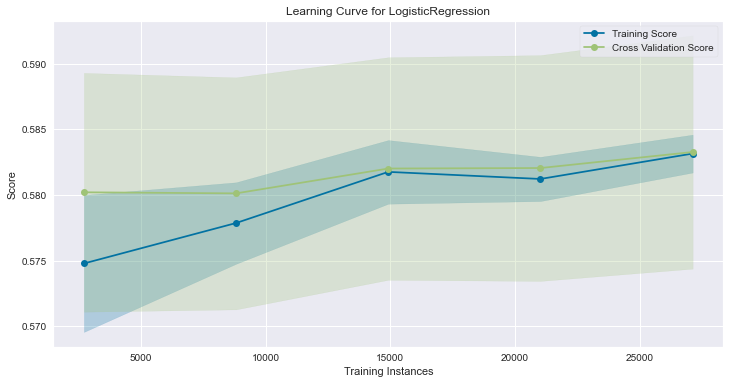

In [50]:
# Visualising the performance of the model on training and validation set using cross validation 

plot_learning_curves(model = lr, data_prepared = data_prepared, label = labels) 

By examining the learning curve, I can see that the model is suffering from high bias and adding more data won't help the model to perform better. The data being highly imbalanced could be one reason for the large bias.

Lowering regularisation, and using a more powerful model are some of the strategies for reducing bias. So, I will try to reduce the regularisation by tweaking the model's hyperparameter and also penalise the model to increase the cost of classification mistakes in the minority class.

In [51]:
# Hyperparameter tuning using GridSearchCV

param_grid = {
    "class_weight": [{0: 1, 1: 7}],
    "solver": ["liblinear"],
    "penalty": ["l1", "l2"], 
    "C": [100, 10, 1.0, 0.1, 0.01]
}

lr_grid = LogisticRegression(random_state = rng)
lr_search = GridSearchCV(lr_grid, param_grid, cv = stratified_kfold, scoring = "balanced_accuracy", return_train_score = True, refit = True)

lr_search.fit(data_prepared, labels)

GridSearchCV(cv=StratifiedKFold(n_splits=10,
        random_state=RandomState(MT19937) at 0x1E37FD4BC40, shuffle=True),
             estimator=LogisticRegression(random_state=RandomState(MT19937) at 0x1E300A3B740),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'class_weight': [{0: 1, 1: 7}],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             return_train_score=True, scoring='balanced_accuracy')

In [52]:
# Displaying the best paramaters

lr_search.best_params_

{'C': 0.1,
 'class_weight': {0: 1, 1: 7},
 'penalty': 'l1',
 'solver': 'liblinear'}

In [53]:
# Evaluating the performance of the hypertuned model on training set

hlr_score = evaluate(model = lr_search.best_estimator_, data_prepared = data_prepared, label = labels)
hlr_score

0.6920918799287357

In [54]:
# Evaluating the performance of the hypertuned model using cross-validation

hlr_val_score = evaluate(model = lr_search.best_estimator_, data_prepared = data_prepared, label = labels, cross_val = True)
hlr_val_score

0.6901115217156397

Despite the fact that hyperparameter tuning significantly increases model performance on both the training and validation sets, I will continue to explore with a more sophisticated model with the aim of achieving much better result.

## **Support Vector Classifier**

In [55]:
# Training the Support Vector Classifier

svc = SVC()
svc.fit(data_prepared, labels)

SVC()

In [56]:
# Evaluating the performance of the model on training set

svc_score = evaluate(model = svc, data_prepared = data_prepared, label = labels)
svc_score

0.5864549553752438

In [57]:
# Evaluating the performance of the model using cross-valiadation

svc_val_score = evaluate(model = svc, data_prepared = data_prepared, label = labels, cross_val = True)
svc_val_score

0.5852230710063132

Support Vector Classifier with default parameters is also underfitting the data.

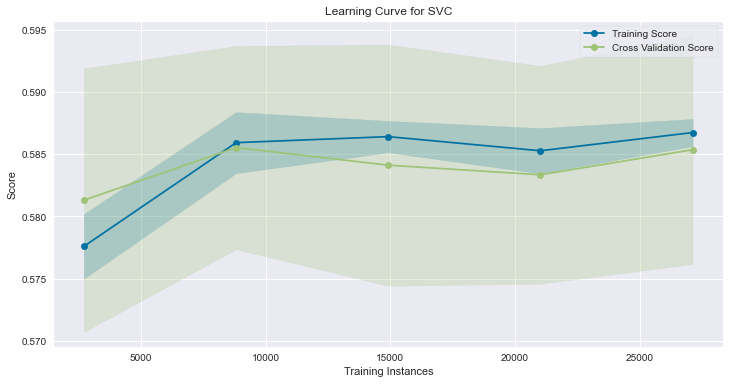

In [58]:
# Visualising the performance of the model on training and validation set using cross validation 

plot_learning_curves(model = svc, data_prepared = data_prepared, label = labels) 

By looking at the learning curve, I can tell that the model seems to have a lot of bias.

So, I'll try to reduce regularisation once again by tweaking the model's hyperparameter, as well as penalise the model to increase the cost of classifying errors on the minority class.

In [59]:
# Hyperparameter tuning using GridSearchCV

param_grid = {
    "class_weight": [{0: 1, 1: 7}],
    "C": [10, 1.0, 0.1]
}

svc_grid = SVC(random_state = rng)
svc_search = GridSearchCV(svc_grid, param_grid, cv = stratified_kfold, scoring = "balanced_accuracy", return_train_score = True, refit = True)

svc_search.fit(data_prepared, labels)

GridSearchCV(cv=StratifiedKFold(n_splits=10,
        random_state=RandomState(MT19937) at 0x1E37FD4BC40, shuffle=True),
             estimator=SVC(random_state=RandomState(MT19937) at 0x1E300A3B740),
             param_grid={'C': [10, 1.0, 0.1], 'class_weight': [{0: 1, 1: 7}]},
             return_train_score=True, scoring='balanced_accuracy')

In [60]:
# Displaying the best paramaters

svc_search.best_params_

{'C': 1.0, 'class_weight': {0: 1, 1: 7}}

In [61]:
# Evaluating the performance of the hypertuned model on training set

hsvc_score = evaluate(model = svc_search.best_estimator_, data_prepared = data_prepared, label = labels)
hsvc_score

0.7347135193195754

In [62]:
# Evaluating the performance of the hypertuned model using cross-validation

hsvc_val_score = evaluate(model = svc_search.best_estimator_, data_prepared = data_prepared, label = labels, cross_val = True)
hsvc_val_score

0.7139397732003049

The performance of the Support Vector Classifier has been significantly improved by hyperparameter tuning, and it now outperforms Logistic Regression.  However, I will continue to experiment with a boosting model because both of the previous models with default parameters have a large bias, and boosting models are capable of offering higher performance when the classifier has a high bias.

## **XGBoost Classifier**

In [63]:
# Training the XGBoost Classifier

xgb = XGBClassifier()
xgb.fit(data_prepared, labels)

[17:42:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
# Evaluating the performance of the model on training set

xgb_score = evaluate(model = xgb, data_prepared = data_prepared, label = labels)
xgb_score

0.7263607557986395

In [65]:
# Evaluating the performance of the model using cross-valiadation

xgb_val_score = evaluate(model = xgb, data_prepared = data_prepared, label = labels, cross_val = True)
xgb_val_score

[17:42:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.6275433337432175

XGBoost Classifier with default parameters also seems to be underfitting the data as well, but it performs slightly well in comparison to the previous models.

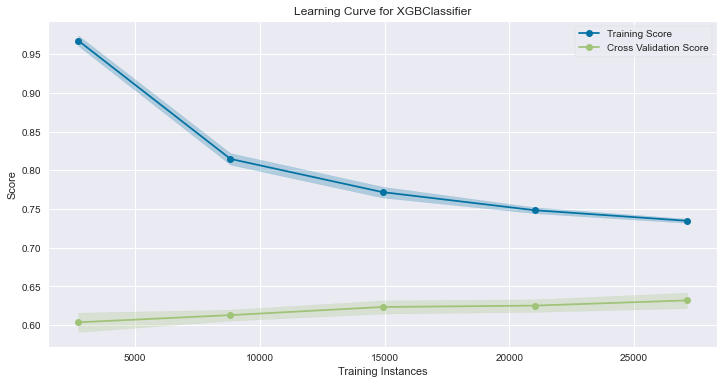

In [66]:
# Visualising the performance of the model on training and validation set using cross validation 

plot_learning_curves(model = xgb, data_prepared = data_prepared, label = labels) 

The learning curve tells us the model is suffering from high bias once again.

I'll try to reduce regularisation once more by tweaking the model's hyperparameter and penalising the model to raise the cost of classification errors on the minority class.

In [67]:
# Hyperparameter tuning using GridSearchCV

param_grid = {
    "scale_pos_weight": [7],
    "reg_alpha": [0, 0.001, 0.005, 0.01, 0.05],
}

xgb_grid = XGBClassifier()
xgb_search = GridSearchCV(xgb_grid, param_grid, cv = stratified_kfold, scoring = "balanced_accuracy", return_train_score = True, refit = True)

xgb_search.fit(data_prepared, labels)

[17:43:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:43:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:44:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:44:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:44:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:44:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=StratifiedKFold(n_splits=10,
        random_state=RandomState(MT19937) at 0x1E37FD4BC40, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
                         'scale_pos_weight': [7]},
             return_train_score=True, scoring='balanced_accuracy')

In [68]:
# Displaying the best paramaters

xgb_search.best_params_

{'reg_alpha': 0.001, 'scale_pos_weight': 7}

In [69]:
# Evaluating the performance of the hypertuned model on training set

hxgb_score = evaluate(model = xgb_search.best_estimator_, data_prepared = data_prepared, label = labels)
hxgb_score

0.8769092149133438

In [70]:
# Evaluating the performance of the hypertuned model using cross-validation

hxgb_val_score = evaluate(model = xgb_search.best_estimator_, data_prepared = data_prepared, label = labels, cross_val = True)
hxgb_val_score

[17:45:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:45:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:45:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

0.7173782027996305

The XGBoost Classifier's performance has been significantly improved through hyperparameter tuning. This model does not appear to underfit or overfit the data, since it produces a decent score and surpasses the performance of both the previous models. As a result, I'll go with XGBoost Classifier as my best model.

# **Feature Importance**

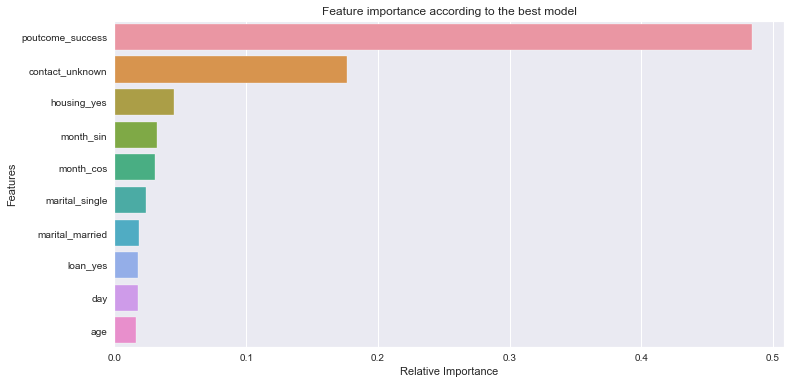

In [71]:
# Feature importance according to the best model

xgb_importance = xgb_search.best_estimator_.feature_importances_

importance_dict = {"Features": subscription_features.columns.tolist(), "Relative Importance": xgb_importance}
importance_df = pd.DataFrame(importance_dict).sort_values(by=['Relative Importance'], ascending=False).head(10)
sns.barplot(x = "Relative Importance", y = "Features", data = importance_df)
plt.title("Feature importance according to the best model")

plt.show()

The above visualisation shows the most important features on which marketing campaign depends.


# **Model Evaluation on Test set**

In [72]:
# Evaluating the performance of the best model on test set

pred = xgb_search.best_estimator_.predict(test_data_prepared)
balanced_accuracy_score(test_subscription_labels, pred)

0.7114220813585206

In [73]:
# Confusion Matrix of the best model

from sklearn.metrics import confusion_matrix
confusion_matrix(test_subscription_labels, pred)

array([[10385,  1592],
       [  705,   882]], dtype=int64)

In [74]:
# Saving the model

joblib.dump(xgb_search.best_estimator_, "model.pkl")

['model.pkl']

# **Conclusion**


The following points are concluded from the project to improve the bank’s marketing campaign:

1. The bank should highly focus on customers who are already enrolled in their previous schemes as they are most likely to opt in for term deposits via a marketing campaign.
2. The bank should target clients whose marital status are single as they are more likely to avail of term deposit.
3. For the next marketing campaign, it will be wise for the banks to focus the marketing campaign during the months of March, September and December.
4. The marketing campaign should be more focused on clients who neither have a house nor a personal loans.
5. The customer's age affects the campaign outcome as well. The next marketing campaign of the bank should target potential clients in their 30s or younger and 60s or older. This will increase the likelihood of more term deposit subscriptions.
6. Clients with average and high balances are more likely to subscribe to a term deposit. 
